# Assignment 4

**Submission deadlines:**

  - Tuesday/Wednesday/Friday groups: 06/07/09.05.2025

**Points:** Aim to get 9 points

# Task 1. Playing with YoLO (from torch.hub)

In this task, you will download pre-trained weights for the YOLOv5 model and use it to detect objects in an image.
You will use the `torch.hub` library to download the model and weights. The model is trained on the COCO dataset, which contains 80 classes of objects.

## Introduction to YoLOv5

### Installation
You need to install OpenCV and PyTorch. You can do this using pip:
```bash
pip install opencv-python torch torchvision
```

### Additional dependencies
In case you have any errors related to OpenCV (missing libgl1.so.1), you may need to install additional dependencies. You can do this using the following command:
```bash
sudo apt install libgl1-mesa-glx libgl1 libglib2.0-0
```

### Downloading the model

In [1]:
import torch
from PIL import Image
import requests
from io import BytesIO


In [2]:
# Download YoLOv5 weights
yolo_model = torch.hub.load("ultralytics/yolov5", "yolov5s")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model.to(device)
yolo_model.eval()

print("YOLOv5 model loaded and ready to use.")

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-6 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


YOLOv5 model loaded and ready to use.


### Inference

💡 ProTip: Input images are automatically transferred to the correct model device before inference.

In [3]:
image_url = "https://ultralytics.com/images/zidane.jpg"

results = yolo_model(image_url)

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


image 1/1: 720x1280 2 persons, 1 tie, 1 cell phone
Speed: 939.7ms pre-process, 88.9ms inference, 498.0ms NMS per image at shape (1, 3, 384, 640)


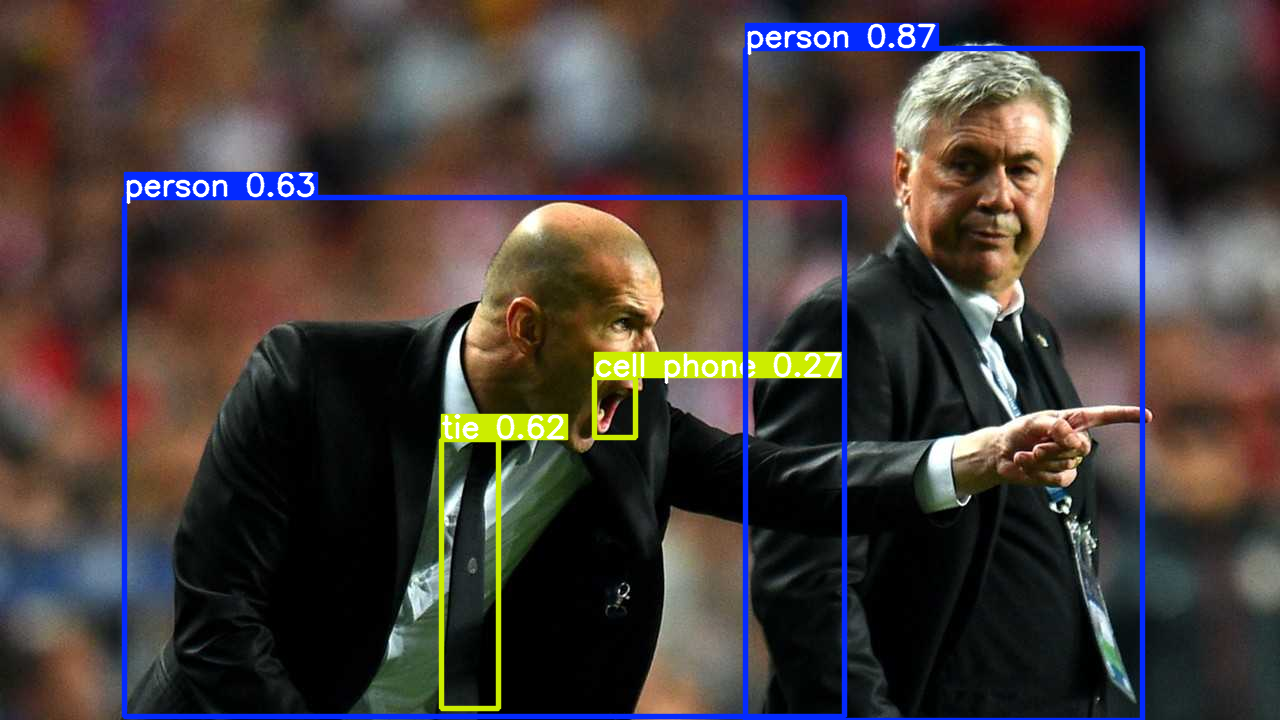

In [4]:
results.print()  # Print results to console
results.show()   # Display results in a window

In [5]:
results.xyxy # Get predictions in xyxy format

[tensor([[7.45579e+02, 4.84703e+01, 1.14269e+03, 7.20000e+02, 8.68910e-01, 0.00000e+00],
         [1.24744e+02, 1.97335e+02, 8.44398e+02, 7.16651e+02, 6.30325e-01, 0.00000e+00],
         [4.41239e+02, 4.39351e+02, 4.98381e+02, 7.08571e+02, 6.16793e-01, 2.70000e+01],
         [5.94082e+02, 3.77300e+02, 6.35424e+02, 4.37148e+02, 2.74014e-01, 6.70000e+01]], device='cuda:0')]

In [6]:
results.xywhn[0]        # Get predictions in xywhn format
results.pandas().xywhn  # Get predictions in pandas DataFrame format

[    xcenter   ycenter     width    height  confidence  class        name
 0  0.737607  0.533660  0.310247  0.932680    0.868910      0      person
 1  0.378571  0.634712  0.562229  0.721272    0.630325      0      person
 2  0.367039  0.797168  0.044642  0.373917    0.616793     27         tie
 3  0.480276  0.565589  0.032299  0.083121    0.274014     67  cell phone]

## Raw predictions

Above, you have already gotten the results after applying Non-Max Suppression (NMS) and thresholding.
The model outputs a list of predictions, which are the bounding boxes (bboxes) around the detected objects.

In this task, you will visualize the raw predictions and implement the NMS and thresholding yourself.

In [7]:
# Here are some additional attributes you can check for the YOLOv5 model
print(yolo_model.conf) # NMS confidence threshold
print(yolo_model.iou)  # NMS IoU threshold

0.25
0.45


Below is the code to load the image into tensor and run `yolo_model.model(image_tensor)` to get the raw predictions.

This will give you a tensor of shape `(1, num_boxes, 85)`, where `num_boxes` is the number of detected boxes and 85 is the number as follows: 4 coordinates of the box, 1 objectness score, and 80 class scores.

In [8]:
import numpy as np
import cv2

response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")
image_np = np.array(image)  # Convert PIL image to NumPy array

# Letterbox resize to 640x640 (preserve aspect ratio with padding)
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114)):
    shape = im.shape[:2]  # current shape [height, width]
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    new_unpad = (int(round(shape[1] * r)), int(round(shape[0] * r)))
    dw = new_shape[1] - new_unpad[0]
    dh = new_shape[0] - new_unpad[1]
    dw /= 2
    dh /= 2
    im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return im

img_letterboxed = letterbox(image_np)
img_tensor = torch.from_numpy(img_letterboxed).permute(2, 0, 1).float() / 255.0
img_tensor = img_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    raw_preds = yolo_model.model(img_tensor)

print("Raw prediction shape:", raw_preds.shape)


Raw prediction shape: torch.Size([1, 25200, 85])


## Problem
1. (**0.25p**) Please describe the output tensor and how to interpret it. Especially, explain the meaning of the 5th number, i.e. the objectness score. How is it calculated and related to the class scores?
2. **1p**  Implement the NMS and thresholding yourself.
3. **1p**  Visualize the raw predictions and the predictions after NMS and thresholding.
4. (**0.25p**) Compare the results with the original predictions.
5. (**0.5p**) Vary IoU threshold for NMS and show its effect on detections.
6. (**1p**) Calculate precision, recall, F1 for different IoU thresholds. Calculate `mAP@0.5` (mean Average Precision at an Intersection over Union (IoU) threshold of 0.5) for the model predictions; see https://www.v7labs.com/blog/mean-average-precision
7. (**1p**) Experiment with your own images. Find examples where NMS removes a valid detection (e.g., overlapping people).


### Bonus points:
8. (**1p**) Implement Soft-NMS and compare results; see https://arxiv.org/abs/1704.04503
Does it help in scenes with many overlapping objects?




In [9]:
%matplotlib inline


In [10]:
import torch
def non_max_suppression(predictions, conf_thresh=0.25, iou_thresh=0.45):

    preds = predictions[0]  # [num_boxes, 85]

    preds = preds[preds[:, 4] > conf_thresh]
    if preds.shape[0] == 0:
        return []

    preds[:, 5:] *= preds[:, 4:5]

    class_scores, class_ids = preds[:, 5:].max(1)

    boxes = preds[:, :4]
    scores = class_scores
    classes = class_ids

    boxes_xy = torch.zeros_like(boxes)
    boxes_xy[:, 0] = boxes[:, 0] - boxes[:, 2] / 2  # x1
    boxes_xy[:, 1] = boxes[:, 1] - boxes[:, 3] / 2  # y1
    boxes_xy[:, 2] = boxes[:, 0] + boxes[:, 2] / 2  # x2
    boxes_xy[:, 3] = boxes[:, 1] + boxes[:, 3] / 2  # y2

    final_detections = []
    unique_classes = classes.unique()

    for c in unique_classes:
        cls_mask = (classes == c)
        cls_boxes = boxes_xy[cls_mask]
        cls_scores = scores[cls_mask]

        sorted_indices = torch.argsort(cls_scores, descending=True)
        cls_boxes = cls_boxes[sorted_indices]
        cls_scores = cls_scores[sorted_indices]

        while cls_boxes.size(0):
            best_box = cls_boxes[0]
            best_score = cls_scores[0]
            final_detections.append(torch.cat([best_box, best_score.unsqueeze(0), c.unsqueeze(0)]))

            if cls_boxes.size(0) == 1:
                break
            ious = compute_iou(best_box.unsqueeze(0), cls_boxes[1:])

            cls_boxes = cls_boxes[1:][ious < iou_thresh]
            cls_scores = cls_scores[1:][ious < iou_thresh]

    if final_detections:
        return torch.stack(final_detections)
    else:
        return []

def compute_iou(box1, box2):

    inter_x1 = torch.max(box1[:, 0], box2[:, 0])
    inter_y1 = torch.max(box1[:, 1], box2[:, 1])
    inter_x2 = torch.min(box1[:, 2], box2[:, 2])
    inter_y2 = torch.min(box1[:, 3], box2[:, 3])

    inter_area = (inter_x2 - inter_x1).clamp(0) * (inter_y2 - inter_y1).clamp(0)
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    union_area = area1 + area2 - inter_area + 1e-6

    return inter_area / union_area

In [11]:
import matplotlib.pyplot as plt
import cv2
import torch

def draw_image(img, title="Image"):
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

def draw_boxes(image, detections, title="Detections", is_raw=False, input_shape=None):
    img = image.copy()

    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if is_raw:
        for det in detections:
            x_c, y_c, w, h, obj_conf = det[:5]
            if obj_conf < 0.25:
                continue
            x1 = int(x_c - w / 2)
            y1 = int(y_c - h / 2)
            x2 = int(x_c + w / 2)
            y2 = int(y_c + h / 2)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, f'{obj_conf:.2f}', (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    else:
        for det in detections:
            x1, y1, x2, y2, score, class_id = det
            x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f'{score:.2f}', (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    draw_image(img, title)


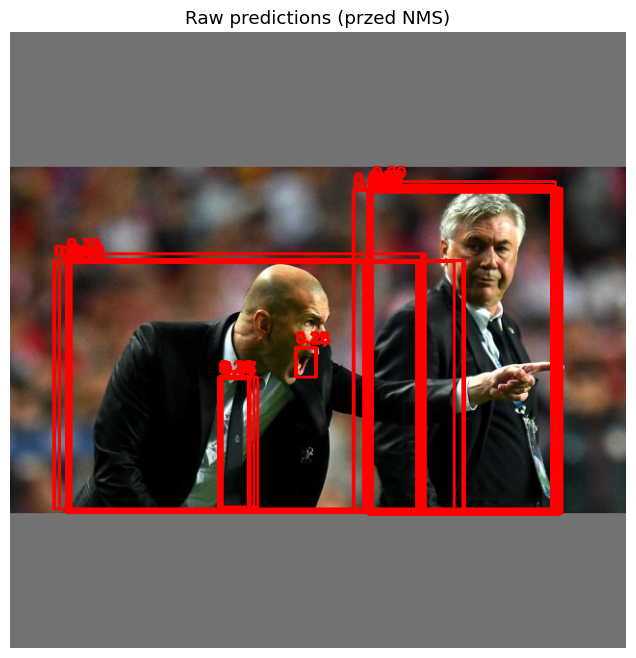

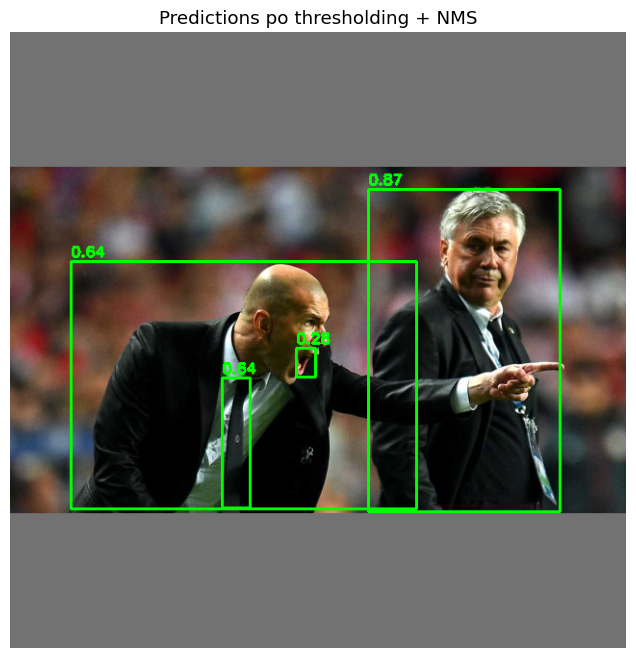

In [12]:

detections = non_max_suppression(raw_preds, conf_thresh=0.25, iou_thresh=0.45)
draw_boxes(img_letterboxed, raw_preds[0], title="Raw predictions (przed NMS)", is_raw=True)

if isinstance(detections, torch.Tensor) and detections.size(0) > 0:
    draw_boxes(img_letterboxed, detections, title="Predictions po thresholding + NMS", is_raw=False)
else:
    print("Brak detekcji po NMS.")

In [13]:

print("Liczba surowych predykcji:", (raw_preds[0][:, 4] > 0.25).sum().item())

detections_nms = non_max_suppression(raw_preds, conf_thresh=0.25, iou_thresh=0.45)

print("Liczba predykcji po NMS:", len(detections_nms))

Liczba surowych predykcji: 40
Liczba predykcji po NMS: 4


In [14]:
ious = [0.1 * i for i in range(1,10)]

for iou_thresh in ious:
    detections_nms = non_max_suppression(raw_preds, conf_thresh=0.25, iou_thresh=iou_thresh)
    print(f"IoU Threshold {iou_thresh}: {len(detections_nms)} detekcji po NMS")

IoU Threshold 0.1: 4 detekcji po NMS
IoU Threshold 0.2: 4 detekcji po NMS
IoU Threshold 0.30000000000000004: 4 detekcji po NMS
IoU Threshold 0.4: 4 detekcji po NMS
IoU Threshold 0.5: 4 detekcji po NMS
IoU Threshold 0.6000000000000001: 4 detekcji po NMS
IoU Threshold 0.7000000000000001: 5 detekcji po NMS
IoU Threshold 0.8: 5 detekcji po NMS
IoU Threshold 0.9: 9 detekcji po NMS


# Task 2. Segmenation

In this task, you will implement a segmentation algorithm.

The dataset for this task is the Oxford Pets dataset (https://www.robots.ox.ac.uk/~vgg/data/pets/). The dataset contains images of cats and dogs, along with their corresponding segmentation masks.
We simplify the masks to binary masks, where the foreground is the animal and the background is everything else; we ignore the border class.
The dataset is split into a training set and a test set. The training set contains ~ 3,700 images, while the test set contains 3,000 images.

Use U-Net to perform binary semantic segmentation.
1. (**0.5p -- 2p**) Implement U-Net (https://arxiv.org/abs/1505.04597) using PyTorch. You may use padded convolutions to avoid losing border pixels. Consider adding batch normalization.
2. (**1p**) Use Binary Cross Entropy to train the model and visualize predictions. Ignore the border class during loss computation.
3. (**1p**) Implement and calculate pixel accuracy, IoU and Dice coefficient.
4. (**1p**) Try different ways to deal with varied input sizes (resize, crop to smaller size, add padding). Then, pick a few images from the test set and perform inference on them while keeping their original size. Compare the results.
5. (**0.5p**) Perform an ablation study on residual connections in the U-Net architecture.



## Installation

In [15]:
!pip install segmentation_models_pytorch -q
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.1 MB/s eta 0:00:00


## Some useful code

In [16]:
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import wandb

from typing import Optional

from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import wrap_dataset_for_transforms_v2, OxfordIIITPet
from torchvision.tv_tensors import Mask
from tqdm.auto import tqdm
import numpy as np

In [17]:
wandb.login();

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: budzynekm09 (budzynekm09-uniwersytet-wroc-awski) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [18]:
class SegmentationDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, transform, length=None):
        self.dataset = dataset
        self.length = len(dataset)
        self.transform = transform

    def __getitem__(self, index):
        image, mask = self.dataset[index]
        return self.transform(image, mask)

    def __len__(self):
        return self.length

def create_wrapped_dataset(dataset, transform):
    wrapped_dataset = wrap_dataset_for_transforms_v2(dataset)
    return SegmentationDatasetWrapper(wrapped_dataset, transform=transform)

# HERE: Set up the size of the images
IMG_SIZE = (128, 128)

transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
target_transform = lambda mask: Mask((2 - mask.squeeze(0)).to(torch.float32))

train_ds_orig = OxfordIIITPet(root=".", target_types="segmentation", download=True, transform=transform, target_transform=target_transform)
train_ds = create_wrapped_dataset(train_ds_orig, transform=v2.Resize(size=IMG_SIZE, antialias=True))

test_ds_orig = OxfordIIITPet(root=".", split="test", target_types="segmentation", download=True, transform=transform, target_transform=target_transform)
test_ds = create_wrapped_dataset(test_ds_orig, transform=v2.Resize(size=IMG_SIZE, antialias=True))

100%|██████████| 792M/792M [00:53<00:00, 14.9MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 9.82MB/s]


### Plot original image and mask

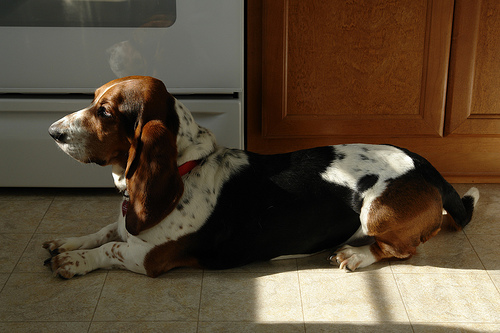

In [19]:
# Plot sample image
image_orig, mask_orig = train_ds_orig[2025]
image_orig

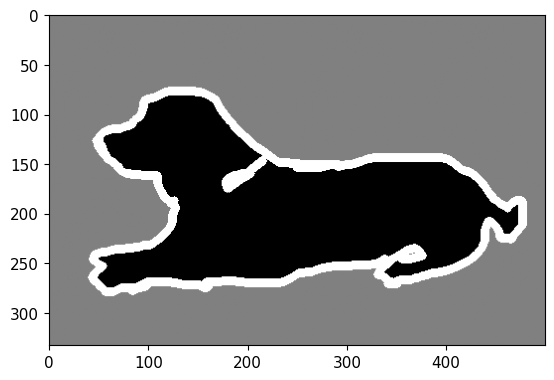

In [20]:
mask_np = np.array(mask_orig)
plt.imshow(mask_np, cmap="gray")
plt.show()

### Plot resized image and mask

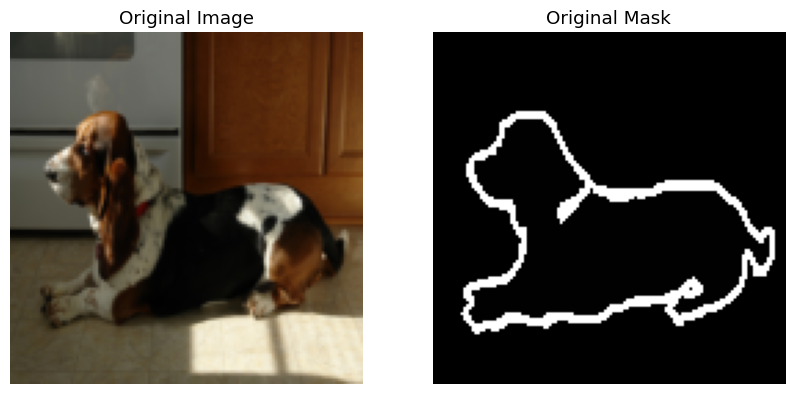

In [21]:
image, mask = train_ds[2025]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(0), cmap="gray")
plt.title("Original Mask")
plt.axis("off")
plt.show()

### Masks

Observe, that we modify the masks (1: foreground, 2: background, 3: border) to be (0: background, 1: foreground, 255: border).

Later we will ignore the border class during loss computation.

In [22]:
mask.unique()  # tensor([0, 1], dtype=torch.uint8)

tensor([  0.,   1., 255.])

In [31]:
# TASK 1.3:
def iou(gt, pred, ignore_index=255, eps=1e-8):
    valid = (gt != ignore_index)
    gt = gt.bool() & valid
    pred = pred.bool() & valid
    intersection = (gt & pred).sum(dim=1).float()
    union = (gt | pred).sum(dim=1).float()
    return intersection / (union + eps)

def dice(gt, pred, ignore_index=255, eps=1e-8):
    valid = (gt != ignore_index)
    gt = gt.bool() & valid
    pred = pred.bool() & valid
    intersection = (gt & pred).sum(dim=1).float()
    gt_sum = gt.sum(dim=1).float()
    pred_sum = pred.sum(dim=1).float()
    return 2 * intersection / (gt_sum + pred_sum + eps)

def accuracy(gt, pred, ignore_index=255):
    valid = (gt != ignore_index)
    correct = ((gt == pred) & valid).sum(dim=1).float()
    total = valid.sum(dim=1).float()
    return correct / (total + 1e-8)




def eval(model, dataloader):
    model.eval()

    metrics = {
        "loss": 0,
        "iou": 0,
        "dice": 0,
        "accuracy": 0,
    }

    ds_len = 0

    for batch in dataloader:
        images, masks = batch
        images = images.cuda()
        masks = masks.cuda()

        batch_size = images.shape[0]
        ds_len += batch_size

        with torch.no_grad():
            loss, logits = model(images, masks)
            loss = loss.mean()
            labels = torch.flatten(torch.sigmoid(logits) > 0.5, 1)
            gt = torch.flatten(masks, 1)

            metrics["loss"] += loss.item() * batch_size
            metrics["iou"] += iou(gt, labels).sum().item()
            metrics["dice"] += dice(gt, labels).sum().item()
            metrics["accuracy"] += accuracy(gt, labels).sum().item()

    for metric in metrics:
        metrics[metric] /= ds_len

    return metrics


## Model

In [24]:
# TASK 1:
# Implement a UNet model
# (2p) implement a UNet model in pure pytorch
# (0.5p) implement a UNet model using segmentation_models_pytorch package
#        (see https://github.com/qubvel-org/segmentation_models.pytorch?tab=readme-ov-file#1-create-your-first-segmentation-model-with-smp),
#        remember to use encoder_weights=None
# Hint:
# - 'resnet18' as the encoder backbone could be a good choice for faster training
# - 'resnet34' as the encoder backbone could be a good choice for better accuracy

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512], ignore_index=255):
        super(UNet, self).__init__()
        self.ignore_index = ignore_index

        self.downs = nn.ModuleList()
        for feature in features:
            self.downs.append(self._double_conv(in_channels, feature))
            in_channels = feature

        self.bottleneck = self._double_conv(features[-1], features[-1]*2)

        self.ups = nn.ModuleList()
        self.up_convs = nn.ModuleList()

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.up_convs.append(self._double_conv(feature*2, feature))

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, labels: Optional[torch.Tensor] = None):
        skip = []
        for down in self.downs:
            x = down(x)
            skip.append(x)
            x = nn.MaxPool2d(2)(x)
        x = self.bottleneck(x)

        for up, conv in zip(self.ups, self.up_convs):
            x = up(x)
            skip_feat = skip.pop()
            if x.shape != skip_feat.shape:
                x = nn.functional.interpolate(x, size=skip_feat.shape[2:])
            x = torch.cat([skip_feat, x], dim=1)
            x = conv(x)

        logits = self.final_conv(x)
        loss = None

        if labels is not None:
            if labels.dim() == 3:
                labels = labels.unsqueeze(1)
            valid_mask = (labels != self.ignore_index)
            labels = labels.to(dtype=logits.dtype)
            crit = BCEWithLogitsLoss(reduction="none")
            loss_map = crit(logits, labels)
            loss = (loss_map * valid_mask.to(dtype=logits.dtype)).sum()
            loss = loss / (valid_mask.sum() + 1e-8)

        return loss, logits


### Create dataloaders

One can experiment with different batch sizes.

In [25]:
train_dataloder = DataLoader(train_ds, batch_size=16, shuffle=True)
test_dataloder = DataLoader(test_ds, batch_size=16, shuffle=False)

## Training

Below is the training loop and some partial results from W&B tracking.
The project is not shared.

In [32]:
ignore_index = 255

config = {
    "learning_rate": 1e-4,
    "epochs": 3,
    "img_size": IMG_SIZE,
}

run = wandb.init(
    project="segmentation_example",
    config=config,
)

unet = UNet(ignore_index=ignore_index).cuda()
optimizer = torch.optim.Adam(unet.parameters(), lr=config["learning_rate"])

for epoch_idx in tqdm(range(config["epochs"]), desc="epoch"):
    unet.train()
    for batch in tqdm(train_dataloder, desc="batch"):
        optimizer.zero_grad()

        images, masks = batch
        images = images.cuda()
        masks = masks.cuda()

        loss, logits = unet(images.cuda(), masks.cuda())
        loss = loss.mean()
        loss.backward()
        optimizer.step()

        labels = torch.flatten(torch.sigmoid(logits) > 0.5, 1)
        gt = torch.flatten(masks, 1)

        run.log({
            "epoch": epoch_idx,
            "train/loss": loss.item(),
            "train/iou": iou(gt, labels).mean(),
            "train/dice": dice(gt, labels).mean(),
            "train/accuracy": accuracy(gt, labels).mean(),
            })

    metrics = eval(unet, test_dataloder)
    for metric, value in metrics.items():
        run.log({f"eval/{metric}": value})
run.finish()

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

batch:   0%|          | 0/230 [00:00<?, ?it/s]

batch:   0%|          | 0/230 [00:00<?, ?it/s]

batch:   0%|          | 0/230 [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅███████████
eval/accuracy,▁▆█
eval/dice,▁▇█
eval/iou,▁▆█
eval/loss,█▂▁
train/accuracy,▃▁▄▂▄▂▅▆▆▆▆▆▅▅▅▆▇▆▇▅▇▇▇▆▇▆▆▇█▆▆▇█▆▆▇▇▆▇█
train/dice,▁▁▁▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▆▇▇▇▇▇▇▇▇██▇███▇█
train/iou,▁▁▆▆▆▆▆▆▅▆▆▆▅▆▇▇▆▇▆▇▇▆▇▇▇▇▆▆▇▇▆▆▆▇▇▇▇▇▇█
train/loss,████▇▆▅▆▄▄▄▅▄▅▄▄▅▄▃▄▃▄▃▃▃▄▃▄▃▃▂▄▄▃▅▂▄▃▃▁
epoch,2
eval/accuracy,0.83658


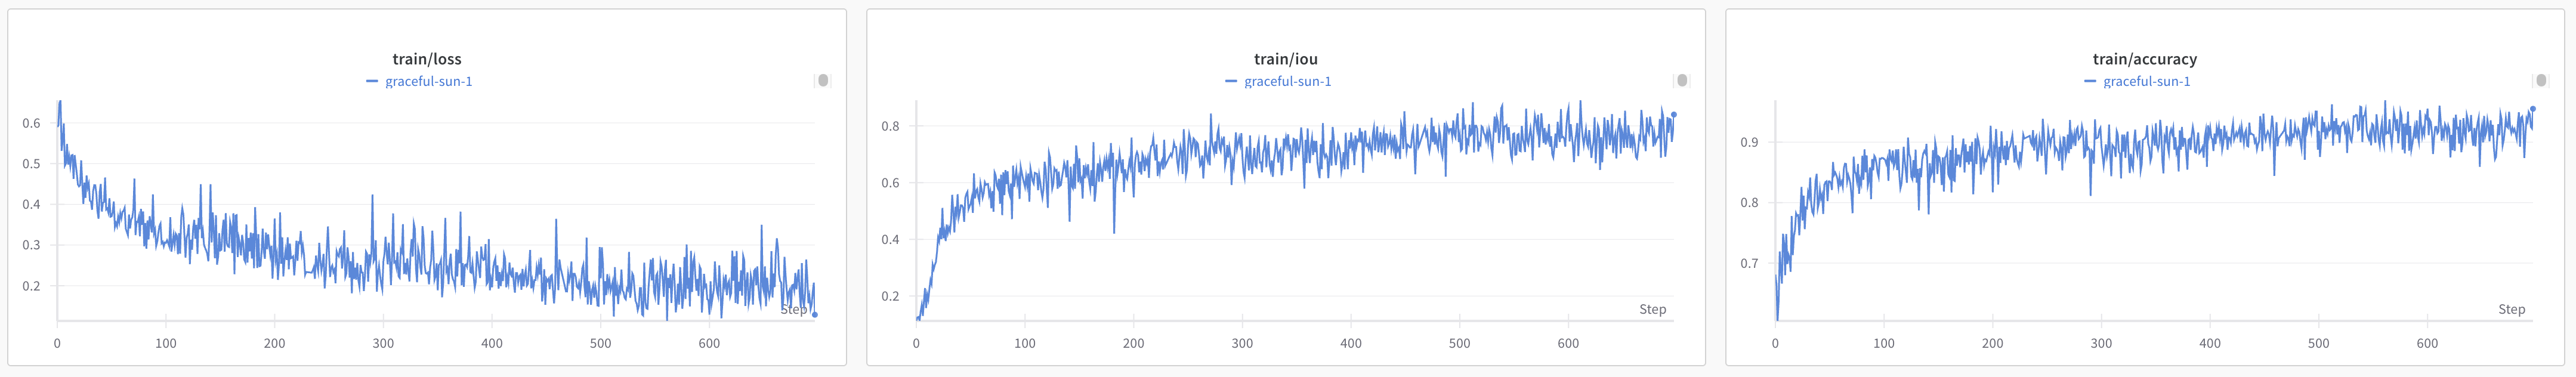

In [ ]:
unet

### Task 2.4

### Task 2.5